In [41]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib
from sklearn.svm import SVC
from itertools import combinations
from collections import Counter

plt.style.use("dark_background")
pd.set_option('display.width', 1000)

In [42]:
try:
    df_train = pd.read_csv('Customer_train.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: 'Customer_train.csv' file not found.")
    df_train = pd.DataFrame()

print("\nFirst five rows of the dataset:")
print(df_train.head())

print("\nDataset Information:")
print(df_train.info())

print("\nStatistical Summary (Numerical Columns):")
print(df_train.describe())

print("\nStatistical Summary (Categorical Columns):")
print(df_train.describe(include=['object']))

print("\nChecking for missing values:")
missing_percentage = df_train.isnull().mean() * 100
print(missing_percentage[missing_percentage > 0].sort_values(ascending=False))

Data loaded successfully.

First five rows of the dataset:
       ID  Gender Ever_Married  Age Graduated     Profession  Work_Experience Spending_Score  Family_Size  Var_1 Segmentation
0  459555  Female           No   28       Yes         Artist              8.0            Low          1.0  Cat_6            B
1  465423    Male          Yes   46       Yes  Entertainment              1.0        Average          4.0  Cat_7            D
2  462941    Male           No   71        No         Lawyer              NaN            Low          2.0  Cat_6            D
3  462609  Female          Yes   52        No         Doctor              4.0            Low          1.0  Cat_4            C
4  462420    Male           No   26       Yes     Healthcare              0.0            Low          3.0  Cat_6            D

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1838 entries, 0 to 1837
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  -----


--- Visualizing Numerical Features ---


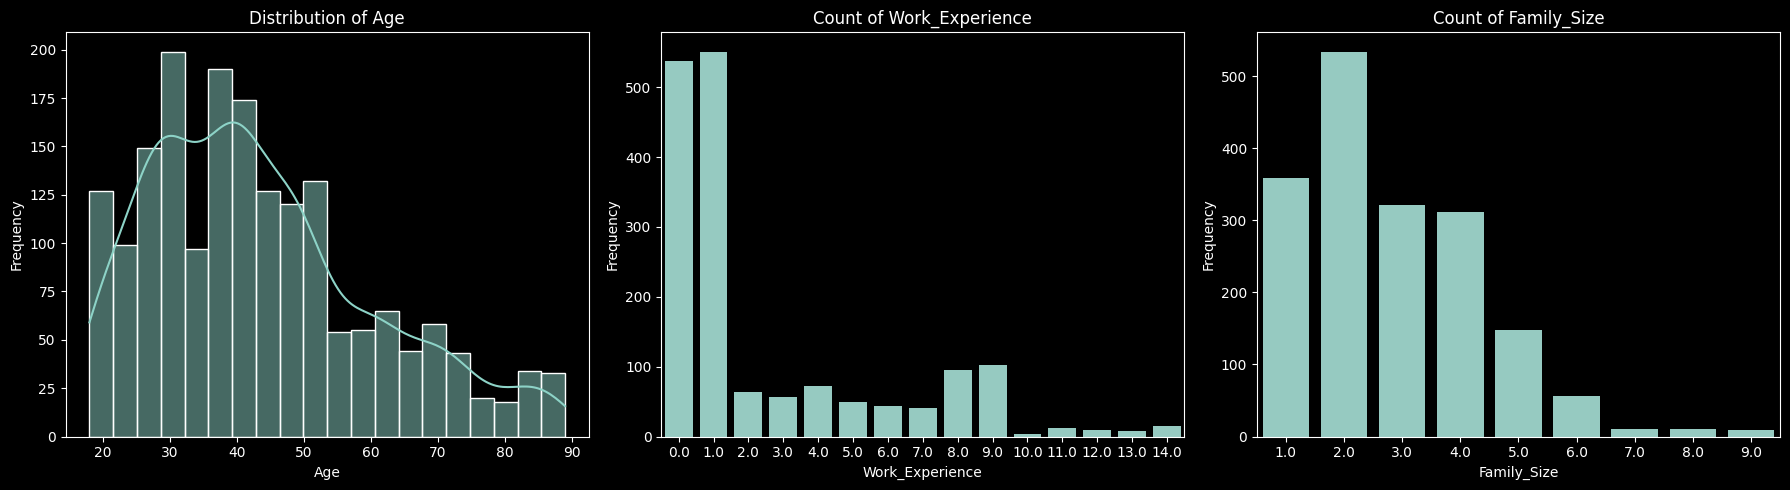


--- Visualizing Categorical Features ---


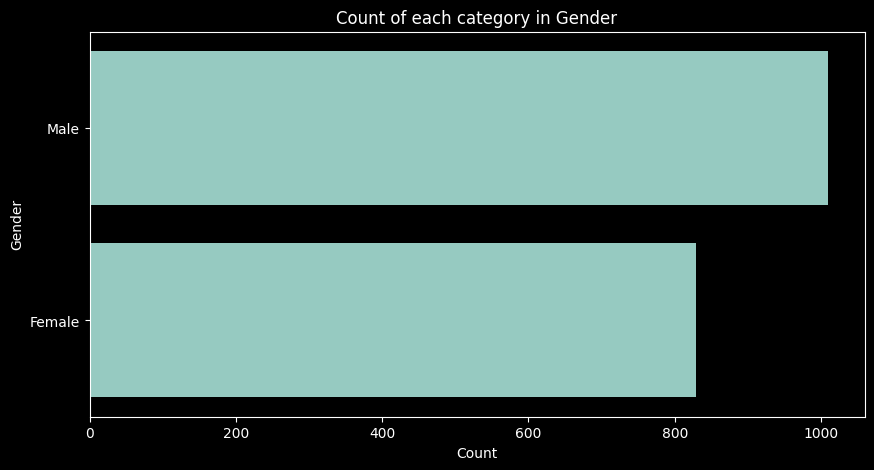

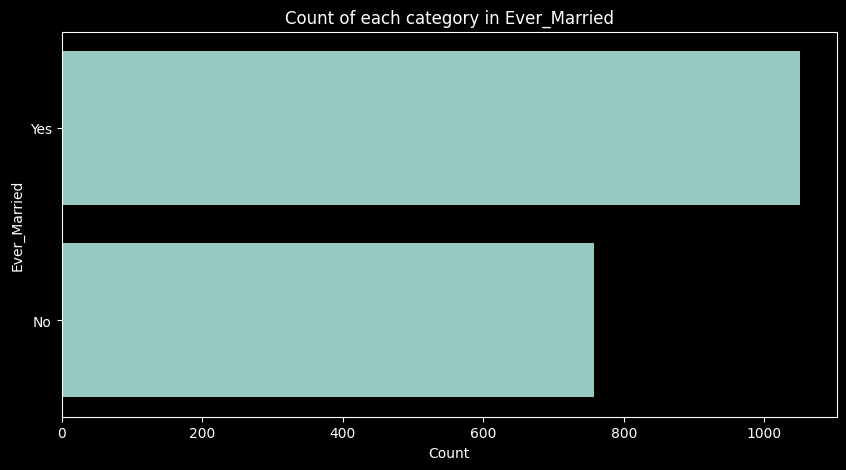

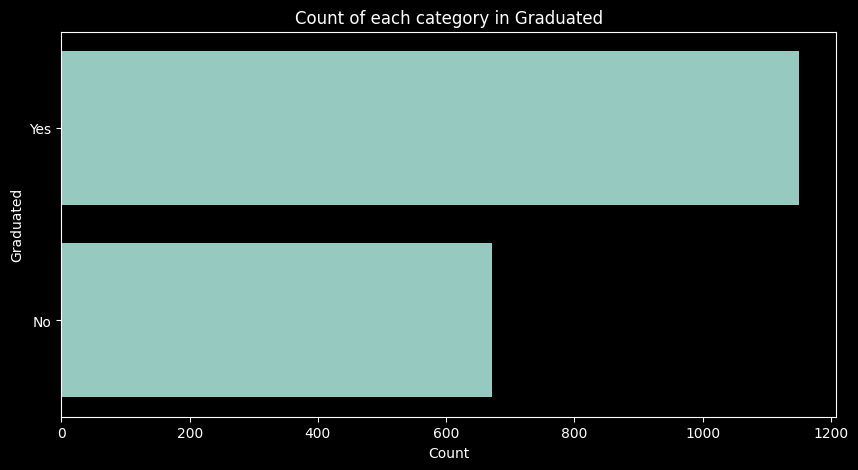

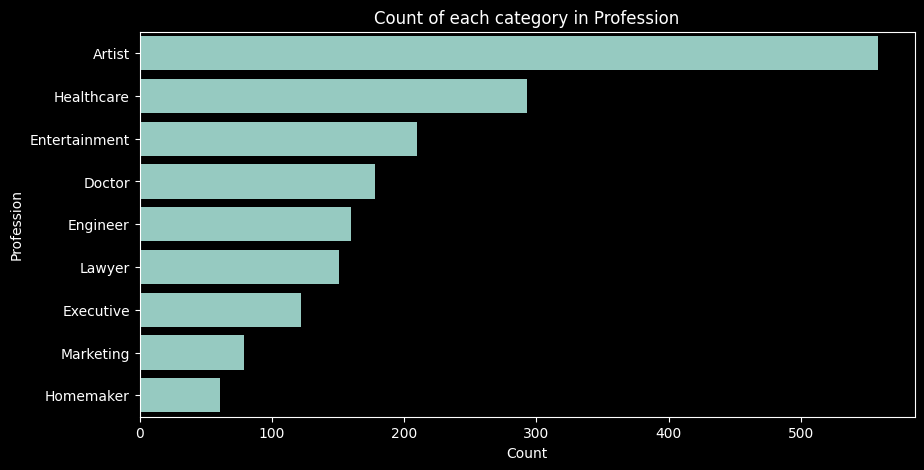

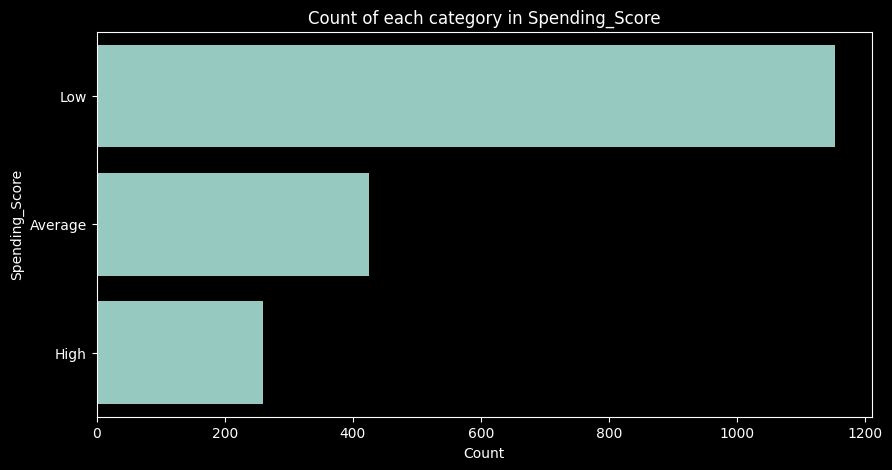

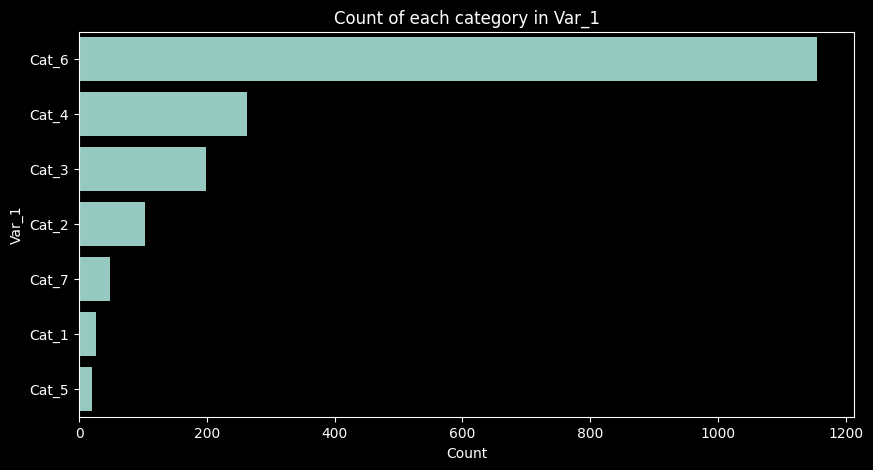

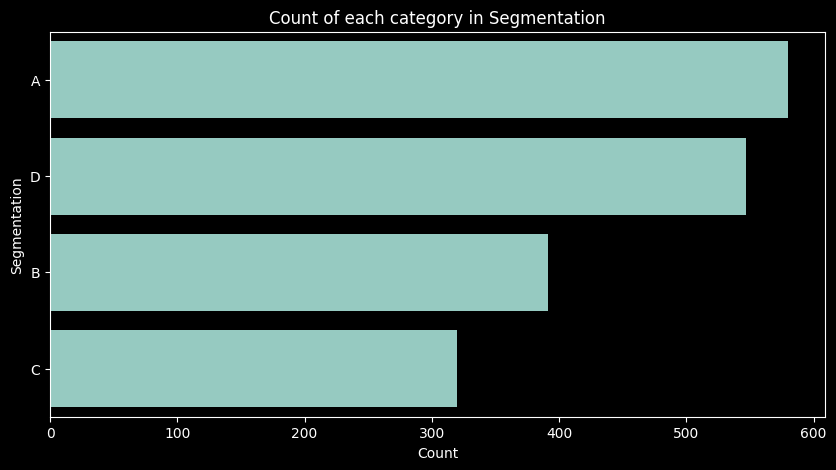


--- Analyzing Feature Relationships with Segmentation ---


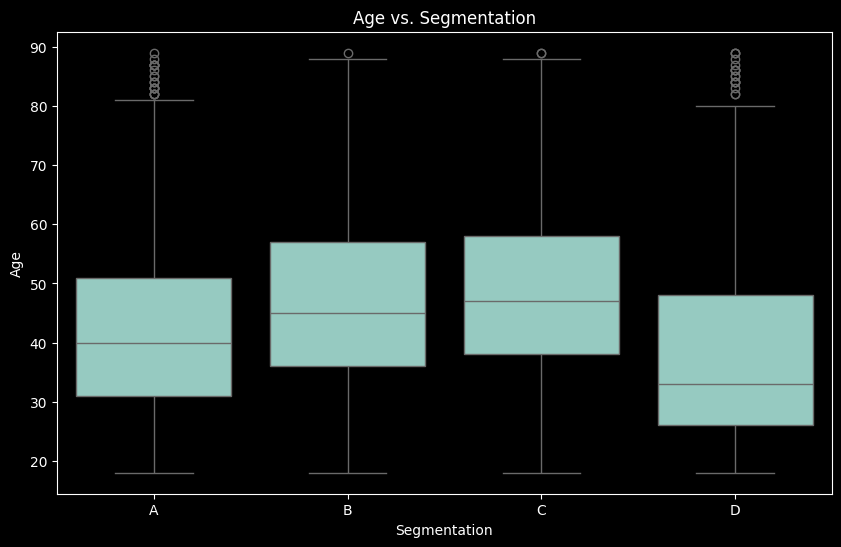

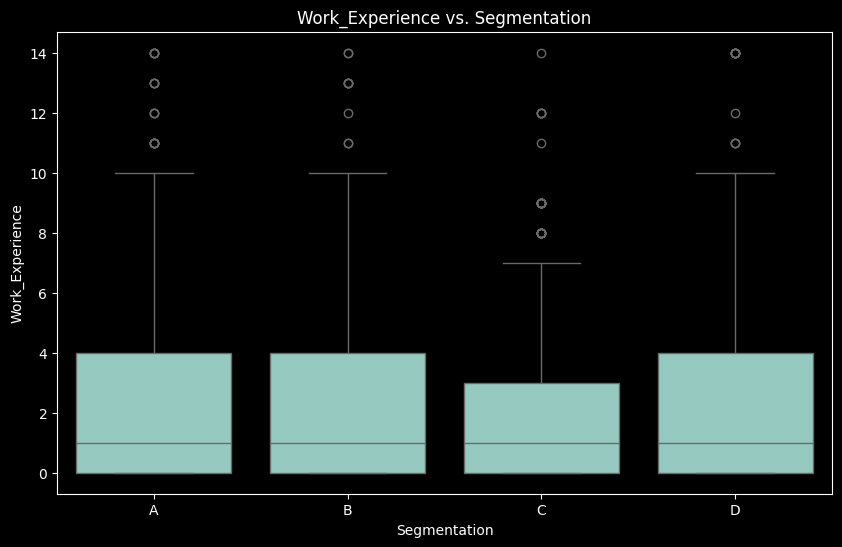

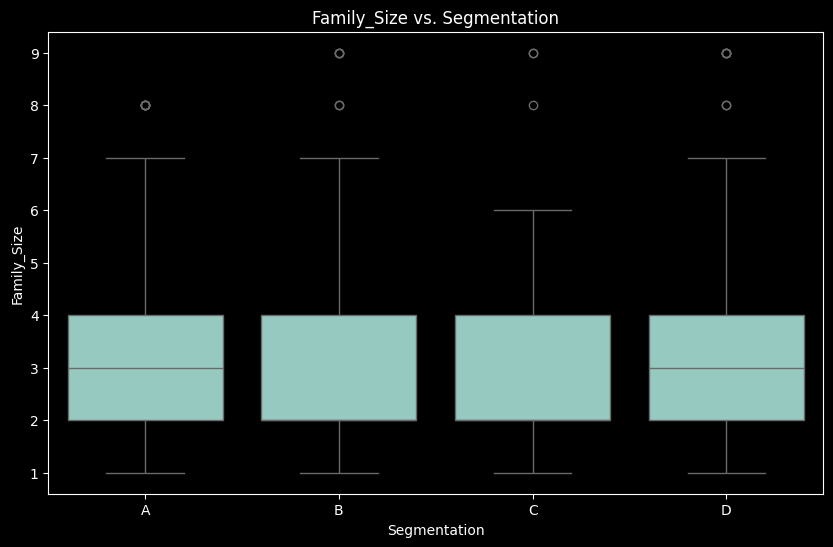

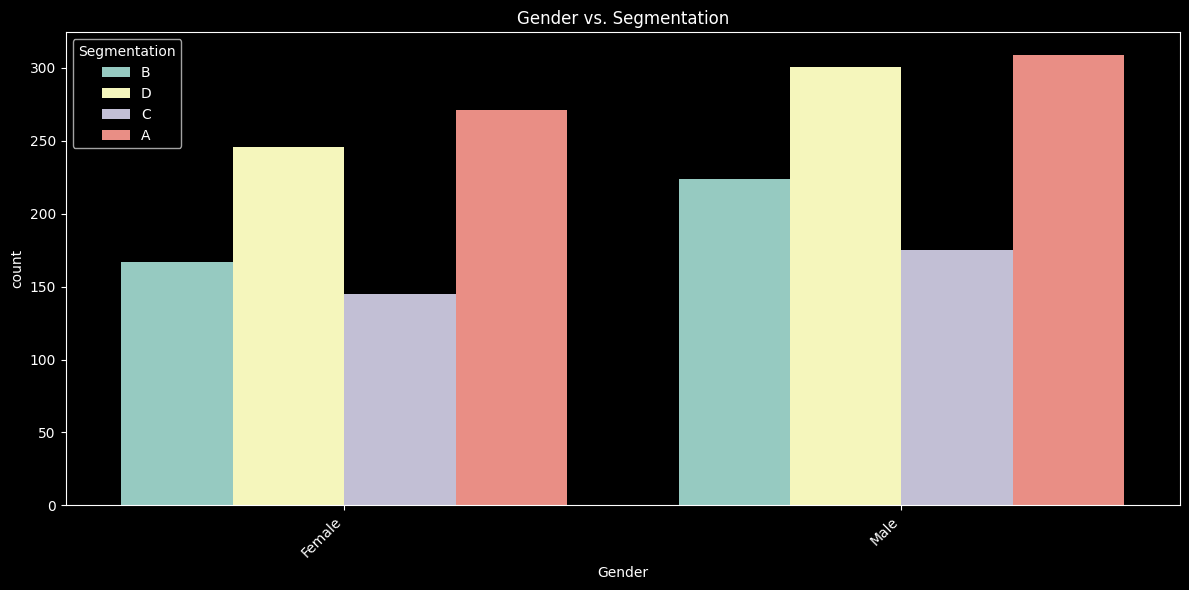

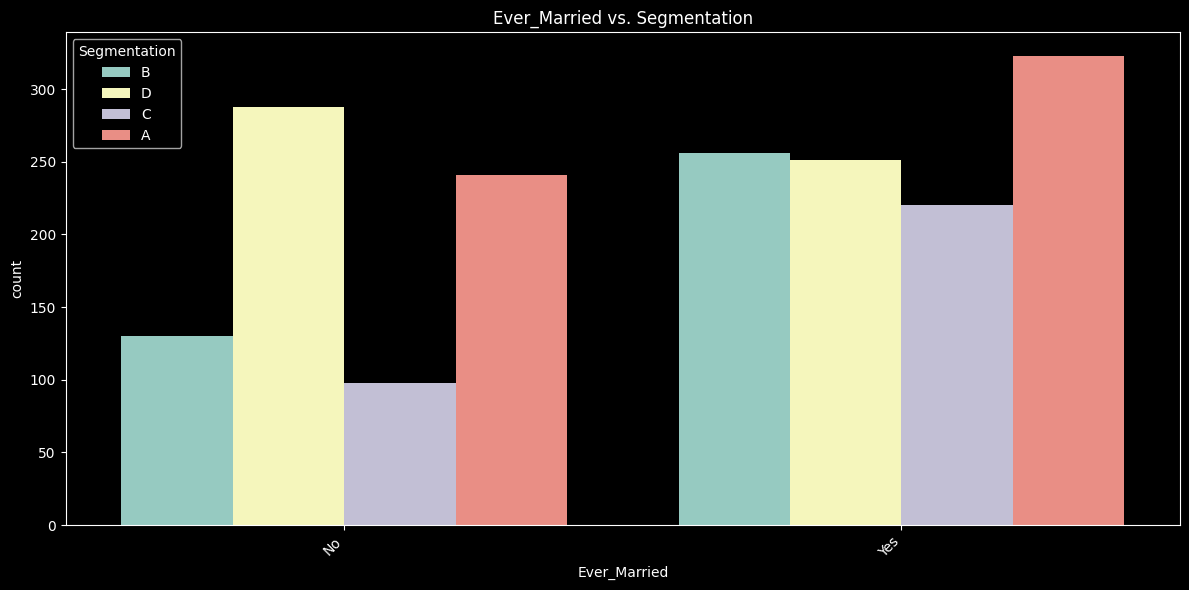

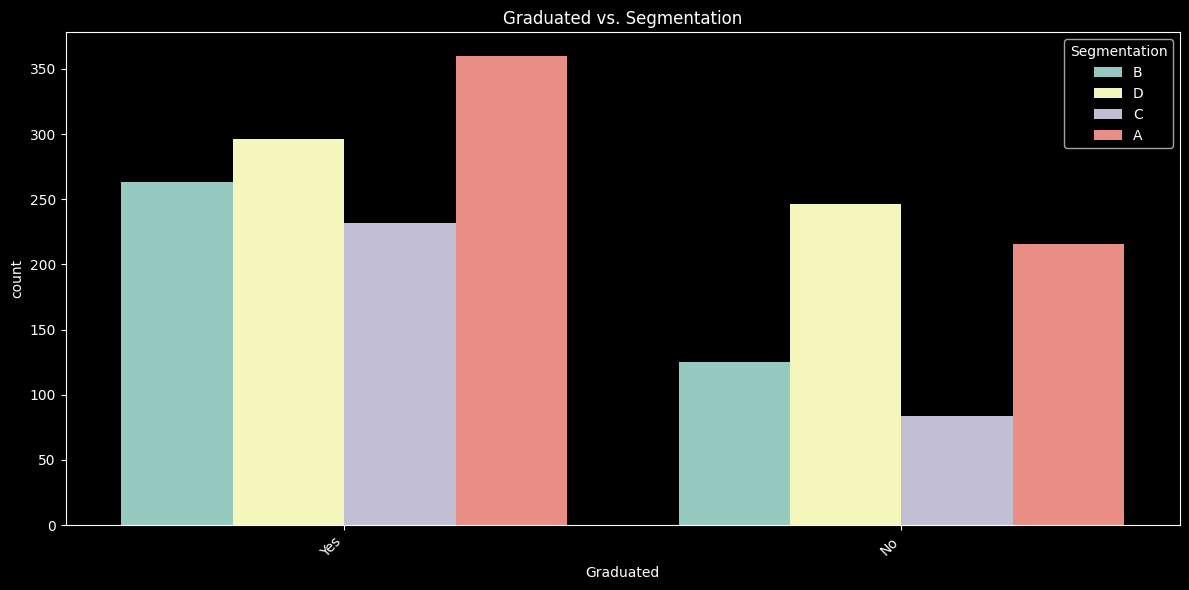

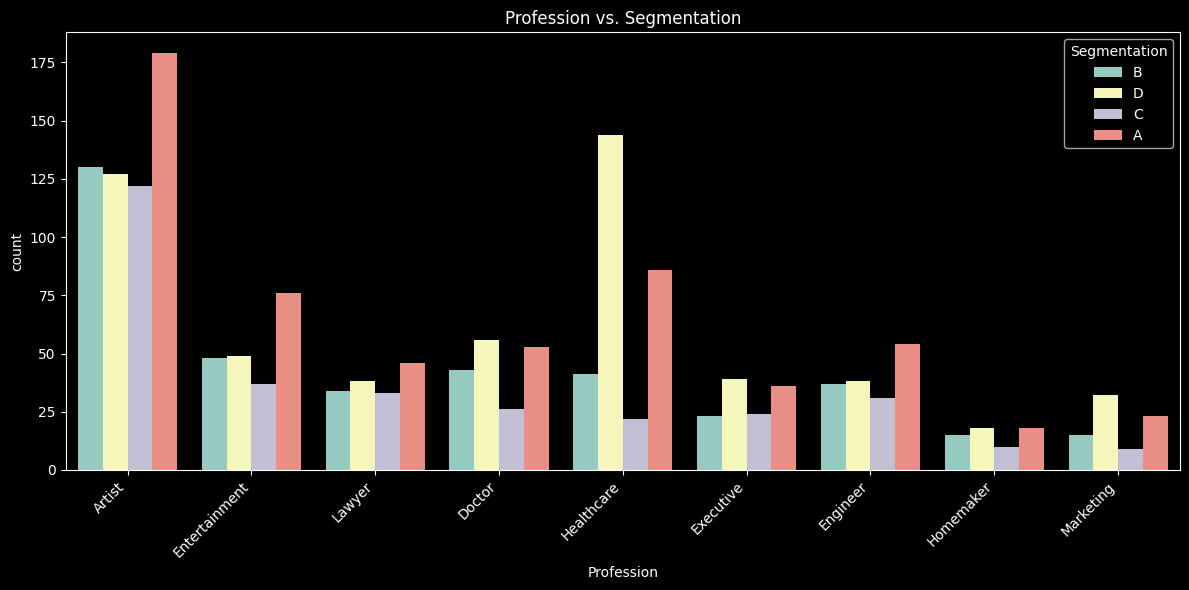

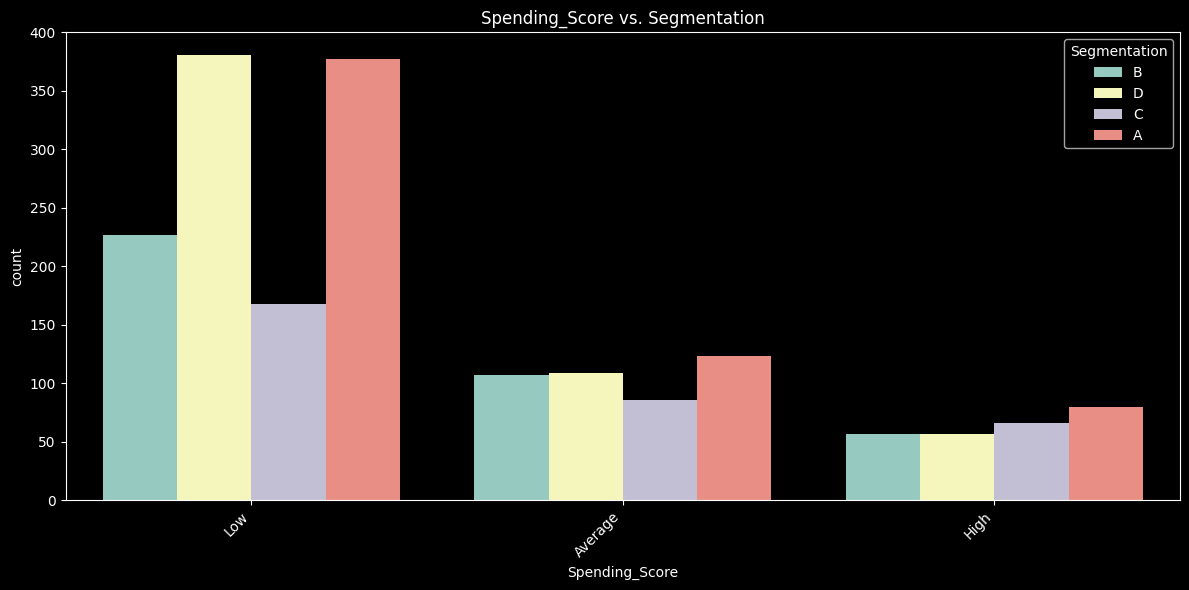

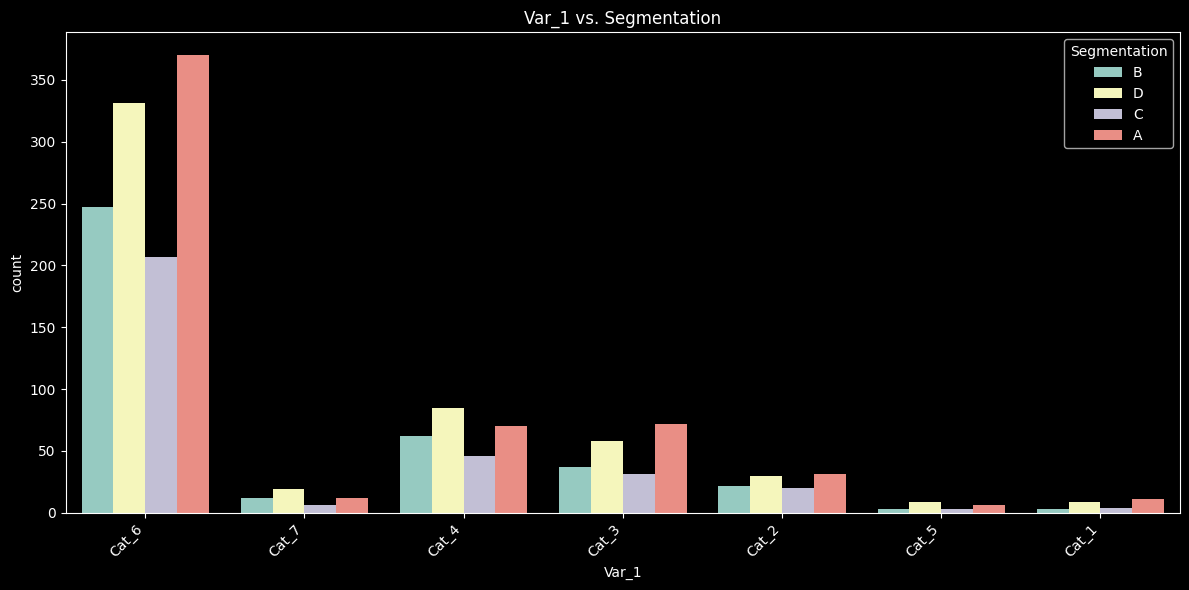

In [43]:
numerical_cols = df_train.select_dtypes(include=np.number).columns.tolist()
if 'ID' in numerical_cols:
    numerical_cols.remove('ID')
categorical_cols = df_train.select_dtypes(include=['object']).columns.tolist()

print("\n--- Visualizing Numerical Features ---")
plt.figure(figsize=(18, 5))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, len(numerical_cols), i + 1)
    if df_train[col].nunique() < 20:
        sns.countplot(x=col, data=df_train)
        plt.title(f'Count of {col}')
    else:
        sns.histplot(df_train[col], kde=True)
        plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

print("\n--- Visualizing Categorical Features ---")
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(y=col, data=df_train, order=df_train[col].value_counts().index)
    plt.title(f'Count of each category in {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.show()

print("\n--- Analyzing Feature Relationships with Segmentation ---")
# Numerical features vs. Segmentation
for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Segmentation', y=col, data=df_train, order=sorted(df_train['Segmentation'].unique()))
    plt.title(f'{col} vs. Segmentation')
    plt.show()

# Categorical features vs. Segmentation
for col in categorical_cols:
    if col != 'Segmentation':
        plt.figure(figsize=(12, 6))
        sns.countplot(x=col, hue='Segmentation', data=df_train)
        plt.title(f'{col} vs. Segmentation')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

In [44]:
df_processed = df_train.copy()

df_processed['Work_Experience_Is_Missing'] = df_processed['Work_Experience'].isnull().astype(int)
print("Created 'Work_Experience_Is_Missing' indicator column.")

# Categorical columns: Impute with mode
for col in ['Ever_Married', 'Graduated', 'Profession', 'Var_1']:
    mode_val = df_processed[col].mode()[0]
    df_processed[col].fillna(mode_val, inplace=True)
    print(f"Missing values in '{col}' filled with mode: '{mode_val}'")

# Numerical columns: Impute with median
for col in ['Family_Size', 'Work_Experience']:
    median_val = df_processed[col].median()
    df_processed[col].fillna(median_val, inplace=True)
    print(f"Missing values in '{col}' filled with median: {median_val}")


print("\nMissing value counts comparison:")
missing_before = df_train.isnull().sum()
missing_after = df_processed.isnull().sum()
missing_comparison = pd.DataFrame({'Before': missing_before, 'After': missing_after})
print(missing_comparison[missing_comparison['Before'] > 0])

Created 'Work_Experience_Is_Missing' indicator column.
Missing values in 'Ever_Married' filled with mode: 'Yes'
Missing values in 'Graduated' filled with mode: 'Yes'
Missing values in 'Profession' filled with mode: 'Artist'
Missing values in 'Var_1' filled with mode: 'Cat_6'
Missing values in 'Family_Size' filled with median: 2.0
Missing values in 'Work_Experience' filled with median: 1.0

Missing value counts comparison:
                 Before  After
Ever_Married       31.0      0
Family_Size        78.0      0
Graduated          16.0      0
Profession         26.0      0
Var_1              22.0      0
Work_Experience   174.0      0


Since around 10% of values in `Work_Experience` are missing, it might be important for prediction, therefore, we create the column which tracks if work experience was missing, `Work_Experience_Is_Missing`.

In [45]:
spending_map = {'Low': 0, 'Average': 1, 'High': 2}
df_processed['Spending_Score'] = df_processed['Spending_Score'].map(spending_map)

# One-Hot Encoding for nominal categorical features
nominal_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Var_1']
df_processed = pd.get_dummies(df_processed, columns=nominal_cols, drop_first=True) # drop_first to avoid dummy variable trap (multicollinearity)

# Separate features (X) and target (y)
X = df_processed.drop(columns=['ID', 'Segmentation'])
y = df_processed['Segmentation']

# Feature Scaling for numerical features
scaler = StandardScaler()
numerical_features_to_scale = ['Age', 'Work_Experience', 'Family_Size']
X[numerical_features_to_scale] = scaler.fit_transform(X[numerical_features_to_scale])

print("\nFirst 5 rows of the final feature matrix (X):")
print(X.head())

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("\nData successfully split into training and validation sets.")
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
classes = np.unique(y_train)
print(f"Target Classes: {classes}")


First 5 rows of the final feature matrix (X):
        Age  Work_Experience  Spending_Score  Family_Size  Work_Experience_Is_Missing  Gender_Male  Ever_Married_Yes  Graduated_Yes  Profession_Doctor  Profession_Engineer  ...  Profession_Healthcare  Profession_Homemaker  Profession_Lawyer  Profession_Marketing  Var_1_Cat_2  Var_1_Cat_3  Var_1_Cat_4  Var_1_Cat_5  Var_1_Cat_6  Var_1_Cat_7
0 -0.916884         1.749144               0    -1.187910                           0        False             False           True              False                False  ...                  False                 False              False                 False        False        False        False        False         True        False
1  0.152916        -0.435334               1     0.810911                           0         True              True           True              False                False  ...                  False                 False              False                 False        F

# One-vs-All (OVA)

In [46]:
ova_classifiers = {}

for cls in classes:
    print(f"Training classifier for: '{cls}' vs The Rest")
    y_binary = (y_train == cls).astype(int)
    svm = SVC(kernel='rbf', probability=True, random_state=42)
    svm.fit(X_train, y_binary)
    ova_classifiers[cls] = svm

print("\n--- OvA Training Complete ---")

def predict_ova(classifiers, X_new):
    class_labels = list(classifiers.keys())
    pred_probs = np.zeros((X_new.shape[0], len(class_labels)))
    for i, cls in enumerate(class_labels):
        pred_probs[:, i] = classifiers[cls].predict_proba(X_new)[:, 1]
    best_class_indices = np.argmax(pred_probs, axis=1)
    final_pred = [class_labels[i] for i in best_class_indices]
    return final_pred

print("\n--- Evaluating OvA model on the validation set ---")
y_pred_val = predict_ova(ova_classifiers, X_val)
accuracy = accuracy_score(y_val, y_pred_val)
print(f"Validation Accuracy of OvA model: {accuracy:.4f}")

Training classifier for: 'A' vs The Rest
Training classifier for: 'B' vs The Rest
Training classifier for: 'C' vs The Rest
Training classifier for: 'D' vs The Rest

--- OvA Training Complete ---

--- Evaluating OvA model on the validation set ---
Validation Accuracy of OvA model: 0.3451


# One-vs-One (OVO)

In [48]:
ovo_classifiers = {}

class_pairs = list(combinations(classes, 2))

for cls1, cls2 in class_pairs:
    print(f"Training classifier for: '{cls1}' vs '{cls2}'")
    
    # Filter the training data to include only samples from the current pair of classes
    pair_indices = y_train.isin([cls1, cls2])
    X_pair = X_train[pair_indices]
    y_pair = y_train[pair_indices]
    
    # Initialize a standard SVM. 
    svm = SVC(kernel='rbf', random_state=42)
    
    svm.fit(X_pair, y_pair)
    
    ovo_classifiers[(cls1, cls2)] = svm

print("\n--- OvO Training Complete ---")

def predict_ovo(classifiers, X_new):
    class_pairs = list(classifiers.keys())
    all_votes = []
    for index in range(X_new.shape[0]):
        sample = X_new.iloc[[index]]
        votes_for_sample = []
        for pair in class_pairs:
            vote = classifiers[pair].predict(sample)[0]
            votes_for_sample.append(vote)
        all_votes.append(votes_for_sample)
        
    final_predictions = [Counter(votes).most_common(1)[0][0] for votes in all_votes]
    
    return final_predictions


print("\n--- Evaluating OvO model on the validation set ---")

y_pred_val_ovo = predict_ovo(ovo_classifiers, X_val)

accuracy_ovo = accuracy_score(y_val, y_pred_val_ovo)
print(f"Validation Accuracy of OvO model: {accuracy_ovo:.4f}")

Training classifier for: 'A' vs 'B'
Training classifier for: 'A' vs 'C'
Training classifier for: 'A' vs 'D'
Training classifier for: 'B' vs 'C'
Training classifier for: 'B' vs 'D'
Training classifier for: 'C' vs 'D'

--- OvO Training Complete ---

--- Evaluating OvO model on the validation set ---
Validation Accuracy of OvO model: 0.3478


In [49]:
imputation_values = {
    'Ever_Married': df_train['Ever_Married'].mode()[0],
    'Graduated': df_train['Graduated'].mode()[0],
    'Profession': df_train['Profession'].mode()[0],
    'Var_1': df_train['Var_1'].mode()[0],
    'Family_Size': df_train['Family_Size'].median(),
    'Work_Experience': df_train['Work_Experience'].median()
}

train_cols = X_train.columns.tolist()

joblib.dump(imputation_values, 'imputation_values.joblib')
joblib.dump(train_cols, 'train_cols.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(ova_classifiers, 'ova_classifiers.joblib')
joblib.dump(ovo_classifiers, 'ovo_classifiers.joblib')

['ovo_classifiers.joblib']